In [1]:
import mmcv
import mmengine
import torch
import matplotlib.pyplot as plt
from mmdet.apis import init_detector, inference_detector
from tabulate import tabulate
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image
import cv2
from mmseg.apis import inference_model, init_model
import mmdet
import mmseg
import mmyolo
import copy
from IPython.display import display
import csv
import os
import time

print('mmcv', mmcv.__version__)
print('mmengine', mmengine.__version__)
print('mmdet', mmdet.__version__)
print('mmseg', mmseg.__version__)
print('mmyolo', mmyolo.__version__)
%pwd

mmcv 2.0.0
mmengine 0.7.3
mmdet 3.0.0
mmseg 1.0.0
mmyolo 0.5.0


'/home/zyj/iono_scaling/mmyolo'

### Model Initialization


#### Init Segmentor


In [2]:
data_root = '../mmsegmentation/data/IonoSeg/'
img_dir = 'rgbimg'
ann_dir = 'rgbmask'
classes = ('Background', 'E', 'Es-l', 'Es-c', 'F1', 'F2', 'Spread-F')
palette = [[255, 255, 255], [250, 165, 30], [120, 69, 125], [53, 125, 34],
           [0, 11, 123], [130, 20, 12], [120, 121, 80]]  # F1 [78, 210, 240]
patches = [mpatches.Patch(color=np.array(
    palette[i]) / 255., label=classes[i]) for i in range(7)]

seg_config_file = '../mmsegmentation/configs/_ionoseg/pspnet_r50_ionogram_mmseg1.py'
seg_checkpoint_file = '../mmsegmentation/work_dirs/se4ionogram/pspnet_r50_ionogram_iou_3922_acc_9153.pth'

seg_model = init_model(seg_config_file, seg_checkpoint_file, device='cuda:0')

/etc/miniconda3/envs/mmlab/lib/python3.8/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/etc/miniconda3/envs/mmlab/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ../mmsegmentation/work_dirs/se4ionogram/pspnet_r50_ionogram_iou_3922_acc_9153.pth


In [3]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class IonogramSegmentationDataset(BaseSegDataset):
    METAINFO = dict(classes=classes, palette=palette)

    def __init__(self, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

In [4]:
def single_load(model, img):
    segs = inference_model(model, img)
    segmap = segs.pred_sem_seg.data.cpu().squeeze(0).numpy()
    return segmap


def post_seg(segmap, img):
    blurred = cv2.GaussianBlur(img, (3, 3), 0)
    edge = cv2.Canny(blurred, 50, 150)
    edge = edge / 255
    segmap = segmap * edge   # Hadamard product
    return segmap


def interpret_numpy(segmap):
    labels = []
    parameters = []
    for class_id in range(1, 7):
        indices = np.where(segmap == class_id)
        if len(indices[0]) != 0:
            parameters.append([np.max(indices[1]), np.max(indices[0])])
            labels.append(class_id - 1)
    # # fmin
    # indices = np.nonzero(segmap)
    # if len(indices[0]) != 0:
    #     fmin = np.min(indices[1])
    return [torch.tensor(parameters), labels]

#### Init Detector


In [5]:
val_dir = './Iono4311/val_images'
test_dir = './Iono4311/test_images'
test_dir = './Iono4311/images' # imgs 

ann_val = './Iono4311/annotations/val.json'
ann_test = './Iono4311/annotations/test.json'

# Choose to use a config and initialize the detector
det_config_file = '/home/zyj/iono_scaling/mmyolo/configs/custom_dataset/yolov5/yolov5_s-v61_fast_1xb96-100e_ionogram.py'
# Setup a checkpoint file to load
det_checkpoint_file = '/home/zyj/iono_scaling/mmyolo/work_dirs/yolov5_s_100e/best_coco-test-0.584.pth'

# build the model from a config file and a checkpoint file
det_model = init_detector(det_config_file, det_checkpoint_file)
det_model.cfg['model']['test_cfg']['nms']['iou_threshold'] = 0.65
print(det_model.cfg['model']['test_cfg'])

annotation = mmengine.load(ann_test)
# 建立 name2index 索引
name2annid = {}
for image in annotation['images']:
    ann_id = []
    for i, ann in enumerate(annotation['annotations']):
        if ann['image_id'] == image['id']:
            ann_id.append(i)
    name2annid[image['file_name']] = ann_id

img_names = []
for image in annotation['images']:
    img_names.append(image['file_name'])

Loads checkpoint by local backend from path: /home/zyj/iono_scaling/mmyolo/work_dirs/yolov5_s_100e/best_coco-test-0.584.pth
{'multi_label': True, 'nms_pre': 30000, 'score_thr': 0.001, 'nms': {'type': 'nms', 'iou_threshold': 0.65}, 'max_per_img': 300}


In [6]:
def get_detection_pred(model, img):
    pred = inference_detector(model, img)
    pred_instances = pred.pred_instances
    if pred_instances.labels.shape.numel() != 0:
        # filter by class
        max_idx = []
        for i in range(torch.max(pred_instances.labels) + 1):
            idx = torch.where(pred_instances.labels == i)[0]
            if len(idx) > 0:
                max_idx.append(idx[torch.argmax(pred_instances.scores[idx])])
        max_idx = torch.tensor(max_idx)
        scores = pred_instances.scores[max_idx].tolist()
        labels = pred_instances.labels[max_idx].tolist()
        bboxes = pred_instances.bboxes[max_idx].cpu()
        params = bboxes[:, 2:4] # [height, frequency]
        
    else:
        scores = pred_instances.scores.tolist()
        labels = pred_instances.labels.tolist()
        bboxes = pred_instances.bboxes.cpu()
        params = [] # [height, frequency]

    return bboxes, params, labels, scores

def get_detection_pred_origin(model, img):
    pred = inference_detector(model, img)
    pred_instances = pred.pred_instances
    if pred_instances.labels.shape.numel() != 0:

        scores = pred_instances.scores.tolist()
        labels = pred_instances.labels.tolist()
        bboxes = pred_instances.bboxes.cpu()
        params = bboxes[:, 2:4] # [height, frequency]
        
    else:
        scores = pred_instances.scores.tolist()
        labels = pred_instances.labels.tolist()
        bboxes = pred_instances.bboxes.cpu()
        params = [] # [height, frequency]

    return bboxes, params, labels, scores

def get_segmentation_pred(model, img, edge=None):
    segmap = single_load(model, img)
    if edge:
        segmap = post_seg(segmap, img)
    parameters, labels = interpret_numpy(segmap)
    return [segmap, parameters, labels]

def interprete_parameters(boundaries, labels):
    # [hE, foE, hEs, foEs, hF1, foF1, hF2, foF2] = [-1] * 8
    params = [-1] * 8
    # labels: parameter_id      labels begin with 0
    boundary2param = {
        0: 0,       # E
        1: 2, 2: 2, # Es
        3: 4,       # F1
        4: 6, 5: 6  # F2, Spread-F
    }
    for i in range(len(labels)):
        params[boundary2param[labels[i]]: boundary2param[labels[i]] + 2] = boundaries[i].tolist()
    return params

def get_gt(file_name):
    # bbox [x1, y1, x2, y2] 
    # x1 refers to the distance between the upperleft point and left boundary,
    # y1 refers to the distance between the upperleft point and the top boundary.
    labels = [annotation['annotations'][i]['category_id'] - 1 for i in name2annid[file_name]]   # labels begin with 0
    bboxes = [annotation['annotations'][i]['bbox'] for i in name2annid[file_name]]
    bboxes = torch.tensor(bboxes)
    parameters = [[box[0] + box[2], box[1] + box[3]] for box in bboxes]
    parameters = torch.tensor(parameters)
    bboxes[:, 2:4] = parameters
    mask = Image.open(f'{data_root}/{ann_dir}/{file_name}')
    return [mask, bboxes, parameters, labels]

### Plot Functions


In [7]:
colors = [[0.98, 0.647, 0.118], [0.471, 0.271, 0.49], [0.208, 0.49, 0.133], [0.307, 0.823, 0.941], [0.51, 0.078, 0.047], [0.471, 0.475, 0.314]]

def show_bboxes(axes, bboxes, catogories, labels=None):
    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    for i, bbox in enumerate(bboxes):
        color = colors[catogories[i]]
        rect = plt.Rectangle(
            xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0],
            height=bbox[3]-bbox[1], fill=False, edgecolor=color, linewidth=1.5)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'w'
            if labels[i][:2] != 'Sp':
                axes.text(rect.xy[0], rect.xy[1] - 6, labels[i],
                        va='center', ha='center', fontsize=10, color=text_color,
                        bbox=dict(facecolor=color, lw=0, pad=0.5))
            else:
                axes.text(rect.xy[0]+bbox[2]-bbox[0]+10, rect.xy[1] - 6, labels[i],
                        va='center', ha='center', fontsize=10, color=text_color,
                        bbox=dict(facecolor=color, lw=0, pad=0.5))


def set_ticks(ax, fontsize=None):
    ax.set_xticks([0, 50, 100, 150, 200, 250, 300, 350, 400], [1.0, 3.5, 6.0, 8.5, 11.0, 13.5, 16.0, 18.5, 21.0], fontsize=fontsize)
    ax.set_yticks([0, 40, 80, 120, 160, 200, 240, 280, 320, 360], [990, 890, 790, 690, 590, 490, 390, 290, 190, 90], fontsize=fontsize)
    ax.set_xlabel('Frequency (MHz)', fontsize=fontsize)
    ax.set_ylabel('Virtual Height (km)', fontsize=fontsize)


def plot_layer_parameters(ax, layer_name, h, f, color='r', h_offset=0, f_offset=0, show_label=True):
    if h > 0:
        ax.axvline(f, color=color, linestyle=":", alpha=0.8)    # foX
        if show_label:
            ax.text(h_offset - 10, -3, f'fo{layer_name}', color=color)
        if layer_name[:2] not in ('Es', 'Sp'): 
            ax.axhline(h, color=color, linestyle="--", alpha=0.8)   # h'X
            if show_label:
                ax.text(401, f_offset + 2, f'h\'{layer_name}', color=color)

# params = [hE, foE, hEs, foEs, hF1, foF1, hF2, foF2]
boundary2param = {
    'E': {'offset': -6, 'param_index':[1, 0], 'color': [colors[0], colors[0]]},
    'Es': {'offset': 0, 'param_index':[3, 2], 'color': [colors[2], colors[1]]},
    'F1': {'offset': 0, 'param_index':[5, 4], 'color': [colors[3], colors[3]]},
    'F2': {'offset': 0, 'param_index':[7, 6], 'color': [colors[4], colors[5]]}
}

def params2txtpos(params, width):
    sorted_params = sorted(params)   # 递增
    text_pos = copy.deepcopy(sorted_params)
    l = len(params)
    deviation = [sorted_params[i + 1] - sorted_params[i] for i in range(0, l-1)]
    for i in range(len(deviation)):
        if deviation[i] < width and deviation[i] != 0:
            text_pos[i] -= (width-deviation[i]) / 2 
            text_pos[i+1] += (width-deviation[i]) / 2 
    mapping = dict(zip(sorted_params, text_pos))
    resorted_lst = [mapping[x] for x in params]

    return resorted_lst

def plot_parameters(ax, params, labels, show_label=True):
    txtpos_f = params2txtpos(params[1:8:2], width=14)
    txtpos_h = params2txtpos(params[0:8:2], width=26)
    for key in boundary2param.keys():
        if key == 'Es' and 2 in labels:
            color = boundary2param[key]['color'][0]
        elif key == 'F2' and 4 in labels: # Es-c or F2
            color = boundary2param[key]['color'][0]
        else:
            color = boundary2param[key]['color'][1]
        plot_layer_parameters(ax, key, params[boundary2param[key]['param_index'][0]], params[boundary2param[key]['param_index'][1]], color=color, 
                              h_offset=txtpos_h[boundary2param[key]['param_index'][1] // 2], f_offset=txtpos_f[boundary2param[key]['param_index'][1] // 2], show_label=show_label)

def show_det_result(file_name, bboxes, boundaries_pred, labels, scores, figsize=(18, 6), img_dir=test_dir, save_dir=None):
    _, axs = plt.subplots(1, 3, figsize=figsize)
    img = mmcv.imread(img_dir + '/' + file_name)
    [axs[i].imshow(255 - img) for i in range(3)]
    axs[0].set_title('Input Ionogram', y=1.018)
    axs[1].set_title('Pred Bboxes', y=1.018)
    axs[2].set_title('Ground Truth', y=1.018)

    if isinstance(bboxes, torch.Tensor):    # x1, y1, x2, y2
        bboxes = bboxes.cpu()
    _, bboxes_gt, boundaries_gt, labels_gt = get_gt(file_name)
    params_pred = interprete_parameters(boundaries_pred, labels)
    params_gt = interprete_parameters(boundaries_gt, labels_gt) # [hE, foE, hEs, foEs, hF1, foF1, hF2, foF2]
    for ax in axs:
        set_ticks(ax)
    plot_parameters(axs[1], params_pred, labels)
    plot_parameters(axs[2], params_gt, labels_gt)
    label_txt = [det_model.dataset_meta['classes'][labels[i]] for i in range(len(labels))]
    scores_label = [label_txt[i] + f': {scores[i]:.2f}' for i in range(len(scores))]
    show_bboxes(axs[1], bboxes, catogories=labels, labels=scores_label)
    show_bboxes(axs[2], bboxes_gt, catogories=labels_gt, labels=[det_model.dataset_meta['classes'][labels_gt[i]] for i in range(len(labels_gt))])
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, file_name.split('.')[0] + '.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    display(plt.show())

def show_det_result_only(file_name, bboxes, boundaries_pred, labels, scores, figsize=(5, 5), img_dir=test_dir, save_dir=None):
    _, axs = plt.subplots(1, 1, figsize=figsize)
    img = mmcv.imread(img_dir + '/' + file_name)
    axs.imshow(255 - img)
    axs.set_title('Pred Bboxes', y=1.018)

    if isinstance(bboxes, torch.Tensor):    # x1, y1, x2, y2
        bboxes = bboxes.cpu()
    params_pred = interprete_parameters(boundaries_pred, labels)
    set_ticks(axs)
    plot_parameters(axs, params_pred, labels)
    label_txt = [det_model.dataset_meta['classes'][labels[i]] for i in range(len(labels))]
    scores_label = [label_txt[i] + f': {scores[i]:.2f}' for i in range(len(scores))]
    show_bboxes(axs, bboxes, catogories=labels, labels=scores_label)
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, file_name.split('.')[0] + '.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    display(plt.show())


# 可视化对比测试集第 90 张图片的输出在不同评价指标下的结果
def compare_metrics_90(file_name, bboxes, boundaries_pred, labels, scores, figsize=(5, 5), img_dir=test_dir, save_dir=None):
    _, axs = plt.subplots(1, 1, figsize=figsize)
    img = mmcv.imread(img_dir + '/' + file_name)
    axs.imshow(255 - img)
    axs.set_title('Pred Bboxes', y=1.018)

    if isinstance(bboxes, torch.Tensor):    # x1, y1, x2, y2
        bboxes = bboxes.cpu()
    _, bboxes_gt, boundaries_gt, labels_gt = get_gt(file_name)
    params_gt = interprete_parameters(boundaries_gt, labels_gt) # [hE, foE, hEs, foEs, hF1, foF1, hF2, foF2]
    params_pred = interprete_parameters(boundaries_pred, labels)
    set_ticks(axs)
    plot_parameters(axs, params_pred, labels)
    plot_parameters(axs, params_gt, labels_gt, show_label=False)
    label_txt = [det_model.dataset_meta['classes'][labels[i]] for i in range(len(labels))]
    scores_label = [label_txt[i] + f': {scores[i]:.2f}' for i in range(len(scores))]
    show_bboxes(axs, bboxes, catogories=labels, labels=None)
    show_bboxes(axs, torch.tensor([[101.1000, 219.6000, 253.9000, 277.7000]]), catogories=[4], labels='F2')
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, file_name.split('.')[0] + '.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    display(plt.show())


def compare_metrics(file_name, bboxes, boundaries_pred, labels, scores, figsize=(5, 5), img_dir=test_dir, save_dir=None):
    _, axs = plt.subplots(1, 1, figsize=figsize)
    img = mmcv.imread(img_dir + '/' + file_name)
    axs.imshow(255 - img)
    axs.set_title('Pred Bboxes', y=1.018)

    if isinstance(bboxes, torch.Tensor):    # x1, y1, x2, y2
        bboxes = bboxes.cpu()
    _, bboxes_gt, boundaries_gt, labels_gt = get_gt(file_name)
    params_gt = interprete_parameters(boundaries_gt, labels_gt) # [hE, foE, hEs, foEs, hF1, foF1, hF2, foF2]
    params_pred = interprete_parameters(boundaries_pred, labels)
    set_ticks(axs)
    plot_parameters(axs, params_pred, labels)
    plot_parameters(axs, params_gt, labels_gt, show_label=False)
    label_txt = [det_model.dataset_meta['classes'][labels[i]] for i in range(len(labels))]
    scores_label = [label_txt[i] + f': {scores[i]:.2f}' for i in range(len(scores))]
    show_bboxes(axs, bboxes, catogories=labels, labels=None)
    show_bboxes(axs, bboxes_gt, catogories=labels_gt, labels=label_txt)
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, file_name.split('.')[0] + '.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    display(plt.show())


def show_seg_result(file_name, segmap, boundaries_pred, labels, figsize=(18, 6), img_dir=test_dir, save_dir=None):
    _, axs = plt.subplots(1, 3, figsize=figsize)
    img = mmcv.imread(img_dir + '/' + file_name)
    mask, _, boundaries_gt, labels_gt = get_gt(file_name)
    axs[0].imshow(img)
    axs[2].imshow(mask)
    seg_res = Image.fromarray(np.uint8(segmap)).convert('P')
    seg_res.putpalette(np.array(palette, dtype=np.uint8))
    axs[1].imshow(np.array(seg_res.convert('RGB')))
    axs[0].set_title('Input Ionogram', y=1.018)
    axs[1].set_title('Seg Map', y=1.018)
    axs[2].set_title('Ground Truth', y=1.018)
    for ax in axs: 
        set_ticks(ax)
    params_pred = interprete_parameters(boundaries_pred, labels)
    params_gt = interprete_parameters(boundaries_gt, labels_gt) # [hE, foE, hEs, foEs, hF1, foF1, hF2, foF2]
    plot_parameters(axs[1], params_pred, labels)
    plot_parameters(axs[2], params_gt, labels_gt)
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, file_name.split('.')[0] + '.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    display(plt.show())


def show_trace(file_name, bboxes, labels, img_dir=test_dir, save_dir=None):
    img = mmcv.imread(img_dir + '/' + file_name)
    gray_img = img[:, :, 0]
    bboxes = bboxes.cpu().int()

    for bbox, label in zip(bboxes, labels):
        if label in [1, 2, 5]:
            continue
        # 提取bbox对应的部分
        x1, y1, x2, y2 = bbox
        bbox_img = gray_img[y1:y2, x1:x2]
        # 对于每个bbox中的横坐标，找到其像素值最大的位置
        max_positions = [np.argmax(bbox_img[:, i]) for i in range(bbox_img.shape[1])]
        # 将每个bbox中像素值最大的位置转换为原始图像的坐标
        max_positions = [(x1 + i, y1 + max_positions[i]) for i in range(len(max_positions))]
        # 将每个bbox中像素值最大的位置转换为原始图像的坐标，并将其添加到对应bbox的轨迹列表中
        plt.plot([p[0] for p in max_positions], [p[1] for p in max_positions], color=colors[label], linewidth=0.8)
    plt.imshow(255 - img, alpha=0.4)
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, file_name.split('.')[0] + '.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    display(plt.show())


def show_scaling_results(file_name, bboxes, boundaries_pred, labels, scores, figsize=(10, 5), img_dir=test_dir, save_dir=None):
    _, axs = plt.subplots(1, 2, figsize=figsize)
    img = mmcv.imread(img_dir + '/' + file_name)
    axs[0].imshow(255 - img)
    axs[1].imshow(255 - img, alpha=0.4)
    axs[0].set_title('Input Ionogram', y=1.018)
    axs[1].set_title('Scaling Results', y=1.018)
    set_ticks(axs[0])
    set_ticks(axs[1])

    if isinstance(bboxes, torch.Tensor):    # x1, y1, x2, y2
        bboxes = bboxes.cpu()
    params_pred = interprete_parameters(boundaries_pred, labels)

    plot_parameters(axs[1], params_pred, labels)
    label_txt = [det_model.dataset_meta['classes'][labels[i]] for i in range(len(labels))]
    # scores_label = [label_txt[i] + f': {scores[i]:.2f}' for i in range(len(scores))]
    scores_label = [label_txt[i] for i in range(len(scores))]
    show_bboxes(axs[1], bboxes, catogories=labels, labels=scores_label)
    
    gray_img = img[:, :, 0]
    bboxes = bboxes.cpu().int()
    for bbox, label in zip(bboxes, labels):
        if label in [1, 2, 5]:
            continue
        # 提取bbox对应的部分
        x1, y1, x2, y2 = bbox
        bbox_img = gray_img[y1:y2, x1:x2]
        # 对于每个bbox中的横坐标，找到其像素值最大的位置
        max_positions = [np.argmax(bbox_img[:, i]) for i in range(bbox_img.shape[1])]
        # 将每个bbox中像素值最大的位置转换为原始图像的坐标
        max_positions = [(x1 + i, y1 + max_positions[i]) for i in range(len(max_positions))]
        # 将每个bbox中像素值最大的位置转换为原始图像的坐标，并将其添加到对应bbox的轨迹列表中
        axs[1].plot([p[0] for p in max_positions], [p[1] for p in max_positions], color=colors[label], linewidth=0.8)

    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, file_name.split('.')[0] + '.png')
        plt.savefig(save_path, dpi=400, bbox_inches='tight')
    display(plt.show())


# post processing
def compare_bboxes(file_name, bboxes, boundaries_pred, labels, scores, figsize=(24, 8), img_dir=test_dir, save_dir=None):
    # if labels[i] in labels_gt and not(all_boundaries_within_threshold(boundaries_pred[i], boundaries_gt[labels_gt.index(labels[i])])):
    #     iou = d2l.box_iou(bboxes_gt[labels_gt.index(labels[i])].unsqueeze(0), bboxes[i].unsqueeze(0))
    #     iou = iou.squeeze()
    #     if iou > 0.5:
    #         print(cnt, labels[i], iou, (boundaries_pred[i] - boundaries_gt[labels_gt.index(labels[i])]) * torch.tensor([0.05, 2.5]))
    #         # show_det_result(img_names[cnt], bboxes, boundaries_pred, labels, scores, save_dir=None)
    #         compare_bboxes(img_names[cnt], bboxes, boundaries_pred, labels, scores, save_dir=None)
    #         cnt += 100
    _, axs = plt.subplots(1, 3, figsize=figsize)
    img = mmcv.imread(img_dir + '/' + file_name)
    axs[0].imshow(255 - img)
    axs[0].set_title('Pred Bboxes', y=1.018)
    axs[1].imshow(255 - img)
    axs[1].set_title('Adjusted Bboxes', y=1.018)
    axs[2].imshow(255 - img)
    axs[2].set_title('Ground Truth', y=1.018)
    for ax in axs:
        set_ticks(ax)
    if isinstance(bboxes, torch.Tensor):    # x1, y1, x2, y2
        bboxes = bboxes.cpu()
    _, bboxes_gt, boundaries_gt, labels_gt = get_gt(file_name)
    params_pred = interprete_parameters(boundaries_pred, labels)
    params_gt = interprete_parameters(boundaries_gt, labels_gt) # [hE, foE, hEs, foEs, hF1, foF1, hF2, foF2]
    
    plot_parameters(axs[0], params_pred, labels)
    plot_parameters(axs[2], params_gt, labels_gt)
    label_txt = [det_model.dataset_meta['classes'][labels[i]] for i in range(len(labels))]
    scores_label = [label_txt[i] + f': {scores[i]:.2f}' for i in range(len(scores))]
    show_bboxes(axs[0], bboxes, catogories=labels, labels=scores_label)
    show_bboxes(axs[2], bboxes_gt, catogories=labels_gt, labels=[det_model.dataset_meta['classes'][labels_gt[i]] for i in range(len(labels_gt))])
    bboxes, boundaries_pred, labels, scores = det_post_process(bboxes, boundaries_pred, labels, scores)
    params_pred = interprete_parameters(boundaries_pred, labels)
    plot_parameters(axs[1], params_pred, labels)
    label_txt = [det_model.dataset_meta['classes'][labels[i]] for i in range(len(labels))]
    scores_label = [label_txt[i] + f': {scores[i]:.2f}' for i in range(len(scores))]
    show_bboxes(axs[1], bboxes, catogories=labels, labels=scores_label)

    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, file_name.split('.')[0] + '.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    display(plt.show())

### Custom Evaluate


#### Evaluation Functions


In [8]:
def boundaries_within_total_threshold(boundaries_pred, boundaries_gt, threshold=10):
    return torch.sum(torch.abs(boundaries_pred - boundaries_gt)) <= threshold

def all_boundaries_within_threshold(boundaries_pred, boundaries_gt, label, threshold=4):
    if label in [0, 1, 4]:
        return torch.all(torch.abs(boundaries_pred - boundaries_gt) <= threshold)
    else:
        return torch.abs(boundaries_pred[0] - boundaries_gt[0]) <= 2 * threshold

def calculate_metrics(TP, FP, num_gts):
    precisions, recalls = [], []
    for i in range(6):
        if num_gts[i] == 0:
            precisions.append(-1)
            recalls.append(-1)
        else:
            precisions.append(TP[i] / (TP[i] + FP[i]))
            recalls.append(TP[i] / num_gts[i])

    # Calculate Metrics
    mean_precision = sum(precisions) / 6
    mean_recall = sum(recalls) / 6
    F1_score = 2 * mean_precision * mean_recall / (mean_precision + mean_recall)
    # overall_precision = sum(TP) / (sum(TP) + sum(FP))
    # overall_recall = sum(TP) / sum(num_gts)
    Layer_names = list(det_model.dataset_meta['classes'])
    Layer_names.extend(['Mean', 'Overall'])
    precisions.extend([mean_precision])
    recalls.extend([mean_recall])
    formatted_precisions = ['{:.4f}'.format(precision) for precision in precisions]
    formatted_recalls = ['{:.4f}'.format(recall) for recall in recalls]
    result_table = list(zip(Layer_names, formatted_precisions, formatted_recalls))
    print(tabulate(result_table, headers=['Layer', 'Precision', 'Recall']))
    print(f'F1_score            {F1_score:.4f}')
    return [x for pair in zip(formatted_precisions, formatted_recalls) for x in pair] + ['{:.4f}'.format(F1_score)]

def evaluate_det(model_zoo, model, iou_thr=0.65, score_thr=0.3, post_process=False, test=True):
    if test:
        img_dir, ann_file = test_dir, ann_test
    else:
        img_dir, ann_file = val_dir, ann_val
    # build the model from a config file and a checkpoint file
    det_model = init_detector(model_zoo[model]['cfg_path'], model_zoo[model]['ckpt_path'])
    det_model.cfg['model']['test_cfg']['nms']['iou_threshold'] = iou_thr
    det_model.cfg['model']['test_cfg']['score_thr'] = score_thr
    print(model, f'test_cfg: iou_thr={iou_thr}, score_thr={score_thr}')

    annotation = mmengine.load(ann_file)
    # 建立 name2index 索引
    name2annid = {}
    img_names = []
    for image in annotation['images']:
        ann_id = []
        for i, ann in enumerate(annotation['annotations']):
            if ann['image_id'] == image['id']:
                ann_id.append(i)
        name2annid[image['file_name']] = ann_id
        img_names.append(image['file_name'])
    
    TP, FP = [0] * 6, [0] * 6
    num_gts = [0] * 6
    cnt = 0
    sample_interval = 1

    for img_name in img_names:
        img = mmcv.imread(f'{img_dir}/{img_name}')
        # Get detection predictions
        bboxes, boundaries_pred, labels, scores = get_detection_pred(det_model, img)
        if post_process:
            bboxes, boundaries_pred, labels, scores = det_post_process(bboxes, boundaries_pred, labels, scores, cnt)

        # Get the ground truth in lists
        labels_gt = [annotation['annotations'][i]['category_id'] - 1 for i in name2annid[img_name]]   # labels begin with 0
        bboxes = [annotation['annotations'][i]['bbox'] for i in name2annid[img_name]]
        bboxes = torch.tensor(bboxes)
        boundaries_gt = [[box[0] + box[2], box[1] + box[3]] for box in bboxes]
        boundaries_gt = torch.tensor(boundaries_gt)
        bboxes[:, 2:4] = boundaries_gt

        # show_det_result(img_names[cnt], bboxes, boundaries_pred, labels, scores, img_dir=img_dir)

        for label in labels_gt:
            num_gts[label] += 1
        for i in range(len(labels)):
            if labels[i] in labels_gt and all_boundaries_within_threshold(boundaries_pred[i], boundaries_gt[labels_gt.index(labels[i])]):
                TP[labels[i]] += 1
            else:
                FP[labels[i]] += 1

        cnt += sample_interval
        if cnt > len(annotation['images']):
            break

    return [model, model_zoo[model]['FLOPs'], '{:.2f}'.format(iou_thr), '{:.2f}'.format(score_thr)] + calculate_metrics(TP, FP, num_gts)


def get_real_parameters(a):
    for i in range(8):
        if i % 2 == 0 and a[i] != -1:  # foX
            a[i] = a[i] * 0.05 + 1
        elif i%2 == 1 and a[i] != -1:
            a[i] = (360 - a[i]) * 2.5 + 90
    param_names = ['foE', 'h\'E', 'foEs', 'h\'Es', 'foF1', 'h\'F1', 'foF2', 'h\'F2']
    unit = ['MHz', 'km'] * 4
    for i in range(8):
        if a[i] != -1:
            print(f'{param_names[i]}: {a[i]:.2f} {unit[i]}')


# Postprocess using ionospheric structure information
def det_post_process(bboxes, boundaries_pred, labels, scores, cnt=None):
    if 4 in labels and 5 in labels:
        # show_det_result(img_names[cnt], bboxes, boundaries_pred, labels, scores)
        idx_f = labels.index(4)
        idx_sf = labels.index(5)
        if scores[idx_f] < scores[idx_sf]:
            idx = idx_f
        else:
            idx = idx_sf
        bboxes = torch.cat([bboxes[:idx], bboxes[idx+1:]], dim=0)
        boundaries_pred = torch.cat([boundaries_pred[:idx], boundaries_pred[idx+1:]], dim=0)
        labels.pop(idx)
        scores.pop(idx)

    return bboxes, boundaries_pred, labels, scores

#### Test Models


In [9]:
model_zoo = {
    'RTMDet-tiny': {
        'type': 'det',
        'cfg_path': './configs/custom_dataset/rtmdet/rtmdet_tiny_fast_1xb32-100e_ionogram.py',
        'ckpt_path': './work_dirs/rtmdet_tiny_100e/bbox_mAP_epoch_100_0.589.pth',
        'FLOPs': 4.88
    },
    'RTMDet-s': {
        'type': 'det',
        'cfg_path': './configs/custom_dataset/rtmdet/rtmdet_s_fast_1xb32-100e_ionogram.py',
        'ckpt_path': './work_dirs/rtmdet_s_100e/bbox_mAP_epoch_94_val_0.586.pth',
        'FLOPs': 4.88
    },
    'YOLOv5-s': {
        'type': 'det',
        'cfg_path': './configs/custom_dataset/yolov5/yolov5_s-v61_fast_1xb96-100e_ionogram.py',
        'ckpt_path': './work_dirs/yolov5_s_100e/best_coco-test-0.584.pth',
        'FLOPs': 7.95
    },
    'YOLOv5-m': {
        'type': 'det',
        'cfg_path': './configs/custom_dataset/yolov5/yolov5_m-v61_fast_1xb32-100e_ionogram.py',
        'ckpt_path': './work_dirs/yolov5_m_100e/best_coco_bbox_mAP_epoch_90.pth',
        'FLOPs': 7.95
    },
    'YOLOv6-s': {
        'type': 'det',
        'cfg_path': './configs/custom_dataset/yolov6/yolov6_s_fast_1xb32-100e_ionogram.py',
        'ckpt_path': './work_dirs/yolov6_s_100e/bbox_mAP_epoch_54_0.594.pth',
        'FLOPs': 24.2
    },
    'YOLOv6-m': {
        'type': 'det',
        'cfg_path': './configs/custom_dataset/yolov6/yolov6_m_fast_1xb32-100e_ionogram.py',
        'ckpt_path': './work_dirs/yolov6_m_100e/bbox_mAP_epoch_76.pth',
        'FLOPs': 24.2
    },
    # 'YOLOv6-l': {
    #     'type': 'det',
    #     'cfg_path': './configs/custom_dataset/yolov6/yolov6_l_fast_1xb32-100e_ionogram.py',
    #     'ckpt_path': './work_dirs/yolov6_l_100e/bbox_mAP_epoch_76.pth',
    #     'FLOPs': 71.33
    # },
    'YOLOv7-tiny': {
        'type': 'det',
        'cfg_path': './configs/custom_dataset/yolov7/yolov7_tiny_fast_1xb16-100e_ionogram.py',
        'ckpt_path': './work_dirs/yolov7_tiny_100e/bbox_mAP_epoch_78_0.568.pth',
        'FLOPs': 6.57
    },
    # 'YOLOv7-x': {
    #     'type': 'det',
    #     'cfg_path': './configs/custom_dataset/yolov7/yolov7_x_fast_1xb32-100e_ionogram.py',
    #     'ckpt_path': './work_dirs/yolov7_x_100e/bbox_mAP_epoch_58.pth',
    #     'FLOPs': 999
    # },
    'mask2former-r50': {
        'type': 'seg',
        'cfg_path': '/home/ubuntu/mmsegmentation/configs/_ionoseg/mask2former_r50_ionogram.py',
        'ckpt_path': '/home/ubuntu/mmsegmentation/work_dirs/mask2former_r50_ionogram/mask2former_r50_iter_40000.pth',
        'FLOPs': 999
    },
    'mask2former-swin-t': {
        'type': 'seg',
        'cfg_path': '/home/ubuntu/mmsegmentation/configs/_ionoseg/mask2former_swint_ionogram.py',
        'ckpt_path': '/home/ubuntu/mmsegmentation/work_dirs/mask2former_swint_ionogram/best_mIoU_iter_28000_iou65.pth',
        'ckpt_path2': '/home/ubuntu/mmsegmentation/work_dirs/mask2former_swint_ionogram/mask2former_swin_iter_40000.pth',
        'FLOPs': 999
    },
    'PSPEdgeNet': {
        'type': 'seg',
        'cfg_path': '../mmsegmentation/configs/_ionoseg/pspnet_r50_ionogram_mmseg1.py',
        'ckpt_path': '../mmsegmentation/work_dirs/se4ionogram/pspnet_r50_ionogram_iou_3922_acc_9153.pth',
        'FLOPs': 989
    }
}

Write Results to CSV Files


In [10]:
# Write the header
header = ['Type', 'Model', 'Post', 'Time(ms)'] \
    + [elem for sublist in [[layer + '_P', layer + '_R'] for layer in classes[1:]] for elem in sublist] \
    + ['mP', 'mR', 'Iono-score']
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
print(header)

['Type', 'Model', 'Post', 'Time(ms)', 'E_P', 'E_R', 'Es-l_P', 'Es-l_R', 'Es-c_P', 'Es-c_R', 'F1_P', 'F1_R', 'F2_P', 'F2_R', 'Spread-F_P', 'Spread-F_R', 'mP', 'mR', 'Iono-score']


In [11]:
post = ' '  # '√' if use prior in the postprocessing

results_csv = 'results.csv'
for model_name in model_zoo.keys():
    TP, FP, num_gts = [0] * 6, [0] * 6, [0] * 6
    cnt, timer = 0, 0
    sample_interval = 1
    if model_zoo[model_name]['type'] == 'det':
        try:
            det_model = init_detector(model_zoo[model_name]['cfg_path'], model_zoo[model_name]['ckpt_path'])
        except:
            continue
        det_model.cfg['model']['test_cfg']['score_thr'] = 0.3
        if post == '√':
            print(f'{model_name} + post')
        else:
            print(model_name)
    else:
        try:
            seg_model = init_model(model_zoo[model_name]['cfg_path'], model_zoo[model_name]['ckpt_path'])
        except:
            continue
        print(model_name)

    # for image in annotation['images']:
    while cnt < len(annotation['images']):
        img = mmcv.imread(test_dir + '/' + img_names[cnt])
        tic1 = time.time()
        if model_zoo[model_name]['type'] == 'det':
            bboxes, boundaries_pred, labels, scores = get_detection_pred(det_model, img)
            if post == '√':
                bboxes, boundaries_pred, labels, scores = det_post_process(bboxes, boundaries_pred, labels, scores, cnt)
        else:
            segmap, boundaries_pred, labels = get_segmentation_pred(seg_model, img, edge=model_name=='PSPEdgeNet')

        # Get the ground truth in lists
        mask, bboxes_gt, boundaries_gt, labels_gt = get_gt(img_names[cnt])
        timer += time.time() - tic1
        
        for label in labels_gt:
            num_gts[label] += 1
        for i in range(len(labels)):
            if labels[i] in labels_gt and all_boundaries_within_threshold(boundaries_pred[i], boundaries_gt[labels_gt.index(labels[i])], labels[i]):
                TP[labels[i]] += 1
            else:
                FP[labels[i]] += 1
        cnt += sample_interval
        if cnt > len(annotation['images']):
            break
    print('time', '{:.1f}'.format(timer/646*1000), 'ms')
    result = [model_zoo[model_name]['type'], model_name, post, '{:.1f}'.format(timer/646*1000)] + calculate_metrics(TP, FP, num_gts)

    with open(results_csv, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(result)

Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x7fbbbf28dca0>
Traceback (most recent call last):
  File "/etc/miniconda3/envs/mmlab/lib/python3.8/tempfile.py", line 440, in __del__
    self.close()
  File "/etc/miniconda3/envs/mmlab/lib/python3.8/tempfile.py", line 436, in close
    unlink(self.name)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp5iie_o_v/tmprwrqhsd1.py'
Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x7fbbbf28dca0>
Traceback (most recent call last):
  File "/etc/miniconda3/envs/mmlab/lib/python3.8/tempfile.py", line 440, in __del__
    self.close()
  File "/etc/miniconda3/envs/mmlab/lib/python3.8/tempfile.py", line 436, in close
    unlink(self.name)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp_i6rr0f4/tmpn8b17kz5.py'
Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x7fbbbf28dca0>
Traceback (most recent call last):
  File "/etc/miniconda3/envs/mmlab/lib/python3.8/tempfile.py", li

Loads checkpoint by local backend from path: ./work_dirs/yolov5_s_100e/best_coco-test-0.584.pth
YOLOv5-s


time 23.7 ms
Layer       Precision    Recall
--------  -----------  --------
E              0.904     0.9317
Es-l           0.81      0.6585
Es-c           0.874     0.874
F1             0.9601    0.9731
F2             0.9791    0.9791
Spread-F       0.8148    1
Mean           0.8903    0.9027
F1_score            0.8965
Loads checkpoint by local backend from path: ./work_dirs/yolov5_m_100e/best_coco_bbox_mAP_epoch_90.pth
YOLOv5-m
time 24.1 ms
Layer       Precision    Recall
--------  -----------  --------
E              0.9046    0.9386
Es-l           0.8241    0.7236
Es-c           0.8309    0.8898
F1             0.9596    0.9596
F2             0.9696    0.9711
Spread-F       0.8261    0.8636
Mean           0.8858    0.891
F1_score            0.8884
Loads checkpoint by local backend from path: ./work_dirs/yolov6_s_100e/bbox_mAP_epoch_54_0.594.pth
YOLOv6-s


/etc/miniconda3/envs/mmlab/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


time 22.3 ms
Layer       Precision    Recall
--------  -----------  --------
E              0.9061    0.9556
Es-l           0.7589    0.6911
Es-c           0.75      0.8976
F1             0.9414    0.9731
F2             0.9696    0.9727
Spread-F       0.75      0.9545
Mean           0.846     0.9074
F1_score            0.8756
Loads checkpoint by local backend from path: ./work_dirs/yolov6_m_100e/bbox_mAP_epoch_76.pth
YOLOv6-m
time 35.4 ms
Layer       Precision    Recall
--------  -----------  --------
E              0.8929    0.9386
Es-l           0.7905    0.6748
Es-c           0.7832    0.8819
F1             0.9536    0.9697
F2             0.9681    0.9727
Spread-F       0.875     0.9545
Mean           0.8772    0.8987
F1_score            0.8878
Loads checkpoint by local backend from path: ./work_dirs/yolov7_tiny_100e/bbox_mAP_epoch_78_0.568.pth
YOLOv7-tiny
time 22.5 ms
Layer       Precision    Recall
--------  -----------  --------
E              0.903     0.9215
Es-l           0.75

/etc/miniconda3/envs/mmlab/lib/python3.8/site-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/etc/miniconda3/envs/mmlab/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ../mmsegmentation/work_dirs/se4ionogram/pspnet_r50_ionogram_iou_3922_acc_9153.pth
PSPEdgeNet
time 14.2 ms
Layer       Precision    Recall
--------  -----------  --------
E              0.7621    0.8089
Es-l           0.4805    0.6016
Es-c           0.7261    0.8976
F1             0.9477    0.9764
F2             0.9665    0.9711
Spread-F       0.8696    0.9091
Mean           0.7921    0.8608
F1_score            0.8250


#### Test on a Single Model


06/13 19:13:25 - mmengine - WARNING - The current default scope "mmseg" is not "mmyolo", `init_default_scope` will force set the currentdefault scope to "mmyolo".
Loads checkpoint by local backend from path: ./work_dirs/yolov5_s_100e/best_coco-test-0.584.pth


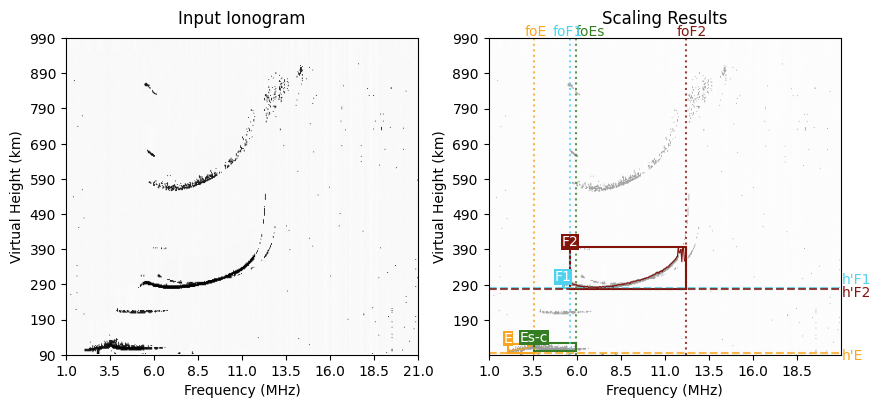

None

time 0.0 ms


In [12]:
TP, FP = [0] * 6, [0] * 6
num_gts = [0] * 6
cnt = 0
sample_interval = 1000
timer = 0
edge = None # whether to use PSPEdgeNet

model_name = 'YOLOv5-s'
if model_zoo[model_name]['type'] == 'det':
    det_model = init_detector(
        model_zoo[model_name]['cfg_path'], model_zoo[model_name]['ckpt_path'])
    det_model.cfg['model']['test_cfg']['score_thr'] = 0.3
else:
    seg_model = init_model(
        model_zoo[model_name]['cfg_path'], model_zoo[model_name]['ckpt_path'])

# for image in annotation['images']:
while cnt < len(annotation['images']):
    img = mmcv.imread(test_dir + '/' + img_names[cnt])
    tic1 = time.time()
    if model_zoo[model_name]['type'] == 'det':
        bboxes, boundaries_pred, labels, scores = get_detection_pred(
            det_model, img)
        # compare_bboxes(img_names[cnt], bboxes, boundaries_pred, labels, scores, save_dir='./_results/compare_boxes')
        bboxes, boundaries_pred, labels, scores = det_post_process(
            bboxes, boundaries_pred, labels, scores, cnt)
    else:
        segmap, boundaries_pred, labels = get_segmentation_pred(
            seg_model, img, edge=model_name == 'PSPEdgeNet')

    # Get the ground truth in lists
    mask, bboxes_gt, boundaries_gt, labels_gt = get_gt(img_names[cnt])
    timer += time.time() - tic1
    show_scaling_results(img_names[cnt], bboxes, boundaries_pred, labels, scores) 

    for label in labels_gt:
        num_gts[label] += 1
    for i in range(len(labels)):
        if labels[i] in labels_gt and all_boundaries_within_threshold(boundaries_pred[i], boundaries_gt[labels_gt.index(labels[i])], labels[i]):
            TP[labels[i]] += 1
        else:
            FP[labels[i]] += 1

    cnt += sample_interval
    if cnt > len(annotation['images']):
        break
print('time', '{:.1f}'.format(timer/646*1000), 'ms')
# calculate_metrics(TP, FP, num_gts);
# # Interprete Prameters
# params_pred = interprete_parameters(boundaries_pred, labels)
# params_gt = interprete_parameters(boundaries_gt, labels_gt)
# print(boundaries_pred, labels, params_pred), get_real_parameters(params_pred);

#### Compare Different Models


In [13]:
def show_comparisons(file_name, segmap1, boundaries_pred1, labels1, segmap2, boundaries_pred2, labels2,
                     bboxes3, boundaries_pred3, labels3, scores3, save_dir=None):
    _, axs = plt.subplots(2, 2, figsize=(15, 14))
    img = mmcv.imread(test_dir + '/' + file_name)

    seg_res1 = Image.fromarray(np.uint8(segmap1)).convert('P')
    seg_res1.putpalette(np.array(palette, dtype=np.uint8))
    axs[0][0].imshow(np.array(seg_res1.convert('RGB')))
    seg_res2 = Image.fromarray(np.uint8(segmap2)).convert('P')
    seg_res2.putpalette(np.array(palette, dtype=np.uint8))
    axs[0][1].imshow(np.array(seg_res2.convert('RGB')))

    axs[1][0].imshow(255-img)
    axs[1][1].imshow(255-img)

    axs[0][0].set_title('PSPEdgeNet', y=1.018)
    axs[0][1].set_title('Mask2Former-r50', y=1.018)
    axs[1][0].set_title('YOLOv5-s', y=1.018)
    axs[1][1].set_title('Ground Truth', y=1.018)
    for axsi in axs:
        for ax in axsi:
            set_ticks(ax, 12)

    params_pred1 = interprete_parameters(boundaries_pred1, labels1)
    plot_parameters(axs[0][0], params_pred1, labels1)
    params_pred2 = interprete_parameters(boundaries_pred2, labels2)
    plot_parameters(axs[0][1], params_pred2, labels2)

    params_pred3 = interprete_parameters(boundaries_pred3, labels3)
    plot_parameters(axs[1][0], params_pred3, labels3)

    label_txt = [det_model.dataset_meta['classes'][labels3[i]]
                 for i in range(len(labels3))]
    scores_label = [label_txt[i] +
                    f': {scores3[i]:.2f}' for i in range(len(scores3))]
    show_bboxes(axs[1][0], bboxes3, catogories=labels3, labels=scores_label)

    _, _, boundaries_gt, labels_gt = get_gt(img_names[cnt])
    # [hE, foE, hEs, foEs, hF1, foF1, hF2, foF2]
    params_gt = interprete_parameters(boundaries_gt, labels_gt)
    plot_parameters(axs[1][1], params_gt, labels_gt)
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, file_name.split('.')[0] + '.png')
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    display(plt.show())


def init_structure_detector(model_name):
    if model_zoo[model_name]['type'] == 'det':
        model = init_detector(
            model_zoo[model_name]['cfg_path'], model_zoo[model_name]['ckpt_path'])
        model.cfg['model']['test_cfg']['score_thr'] = 0.3
    else:
        model = init_model(
            model_zoo[model_name]['cfg_path'], model_zoo[model_name]['ckpt_path'])
    return model, model_zoo[model_name]['type']

In [14]:
# # 比较seg1，seg2，det，gt
# TP, FP = [0] * 6, [0] * 6
# num_gts = [0] * 6
# cnt = 460   # 639, 460
# sample_interval = 1000

# # for image in annotation['images']:
# img = mmcv.imread(test_dir + '/' + img_names[cnt])
# print(cnt, img_names[cnt])

# PSPEdgeNet, _ = init_structure_detector('PSPEdgeNet')
# segmap1, boundaries_pred1, labels1 = get_segmentation_pred(
#     PSPEdgeNet, img, edge=True)

# Mask2Former, _ = init_structure_detector('mask2former-r50')
# segmap2, boundaries_pred2, labels2 = get_segmentation_pred(
#     Mask2Former, img, edge=None)

# YOLOv5, _ = init_structure_detector('YOLOv5-s')
# bboxes3, boundaries_pred3, labels3, scores3 = get_detection_pred(YOLOv5, img)
# bboxes3, boundaries_pred3, labels3, scores3 = det_post_process(
#     bboxes3, boundaries_pred3, labels3, scores3, cnt)

# show_comparisons(img_names[cnt], segmap1, boundaries_pred1, labels1, segmap2, boundaries_pred2,
#                  labels2, bboxes3, boundaries_pred3, labels3, scores3, save_dir='./_results/comparisons')

#### Evaluation with COCO Metrics


In [15]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
AP50s = []
model_name = 'RTMDet-tiny'
annFile = ann_test  # COCO 数据集的标注文件路径
annotation = mmengine.load(annFile)

for model_name in model_zoo.keys():
    if model_zoo[model_name]['type'] == 'det' and model_name[:4] != 'RTMD':
        det_model = init_detector(model_zoo[model_name]['cfg_path'], model_zoo[model_name]['ckpt_path'])
        det_model.cfg['model']['test_cfg']['score_thr'] = 0.3
    else:
        continue

    results_COCO = []
    for image in annotation['images']:
        img = mmcv.imread(test_dir + '/' + image['file_name'])   # 修改路径
        pred = inference_detector(det_model, img)
        pred_instances = pred.pred_instances
        pred_instances = pred_instances[pred_instances.scores > 0.1]
        bboxs = pred_instances.bboxes
        bboxs[:, 2], bboxs[:, 3] =  bboxs[:, 2] - bboxs[:, 0], bboxs[:, 3] - bboxs[:, 1]
        bboxs = bboxs.tolist()
        scores = pred_instances.scores.tolist()
        labels = pred_instances.labels.tolist()
        for i in range(len(labels)):
            pred_dict = {
                "image_id": image['id'],
                "category_id": labels[i] + 1,
                "bbox": bboxs[i],   # [x, y, width, height]
                "score": scores[i]
            }
            results_COCO.append(pred_dict)

    cocoGt = COCO(annFile)
    cocoDt = cocoGt.loadRes(results_COCO)
    cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

    AP50s.append(model_name)
    AP50s.append('{:.3f}'.format(cocoEval.stats[1]))

Loads checkpoint by local backend from path: ./work_dirs/yolov5_s_100e/best_coco-test-0.584.pth


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.860
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.588
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.694
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.842
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.626
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.630
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [16]:
print(AP50s)

['YOLOv5-s', '0.860', 'YOLOv5-m', '0.836', 'YOLOv6-s', '0.859', 'YOLOv6-m', '0.839', 'YOLOv7-tiny', '0.824']
